# Topic Modeling
Using topic modeling we will see if we can produce some easy to understand topics to make this data more valuable. We will be experimenting with different topic modeling algorithms and metrics, to see which one will produce the best results.

We will be using 3 different topic models:

- LSI (Latent Semantic Indexing)
- HDP (Hierarchical Dirichlet Process)
- LDA (Latent Dirichlet Allocation)
- LDA (Tweaked with topic coherence to find optimal number of topics)
- LDA (Mallet) and
- LDA (Mallet, tweaked with topic coherence to find optimal number of topics)

We also run both the regular LDA and Mallet LDA twice, one with the predetermined amount of topics for comparison and one where we determine the optimal number of topics using topic coherence.

First we'll fit those topic models on our existing data then we'll compare them against each other and see how they rank in terms of human interpretability using metrics such as coherence and perplexity.

In [1]:
import os
import re
import operator
import collections
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy for pos tagging and lemmatization
import spacy
import nl_core_news_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Progress bar
from tqdm import tqdm

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# Loading the data from a csv or excel file
data = pd.read_csv('2013-2018.csv', error_bad_lines=False);
#data = pd.read_excel('exceldata.xlsx', error_bad_lines=False);

# Only keeping rows with dutch remarks
data = data.loc[data['Taal'] == 'nl']

data['Opmerking']= data['Opmerking'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27617 entries, 0 to 32481
Data columns (total 9 columns):
Unnamed: 0        27617 non-null int64
Brin              27617 non-null object
Croho             27617 non-null object
CrohoNo           10437 non-null float64
Jaar              27617 non-null int64
OpleidingsVorm    23728 non-null object
Opmerking         27617 non-null object
Taal              27617 non-null object
Degree            27617 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [3]:
# Configuration
randomseed = 100

default_topics = 10

default_limit = 50
default_start = 5
default_step = 5

os.environ['MALLET_HOME'] = 'C:\\mallet\\mallet-2.0.8\\'
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bat' # update this path

## Preprocessing the data
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:

    Removing punctuation and converting everything to lowercase.
    Tokenization
    Stopword removal using NLTK's dutch, english and german stopwords datasets.
    Building Bigrams (frequently co-occuring tokens) using gensim's Phrases.
    Lemmatization to only keep the nouns, adjectives, verbs and adverbs. 

In [4]:
documents = data

### Removing punctuation and converting to lowercase
We start by removing all punctuation and converting everything to lowercase.

In [5]:
# Removing punctuation
#documents['Opmerking_processed'] = documents['Opmerking'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#documents['Opmerking_processed'] = documents['Opmerking_processed'].map(lambda x: x.lower())

documents['Opmerking'].head()

0    het lesrooster was de vorige perioden veel bet...
1    maak een duidelijkere link tussen de stage en ...
2    door de te grote opdrachten en de grote reisti...
3    de gekozen modules zijn niet voor iedereen eve...
4    sneller reageren op vragen die naar examencomm...
Name: Opmerking, dtype: object

### Tokenization and removing stopwords
Stopwords are words that add nothing to a sentence, we filter these words out because otherwise they will be noise for the algorithm which will decrease the performance. We're using the NLTK stopwords datasets for Dutch, English and German, since those are the main languages in which the survey has been filled out by students of Fontys.

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('dutch'))
stop_words.extend(stopwords.words('german'))

# Use the function below to extend the amount of stopwords
# stop_words.extend(['1', '2'])

# Define function for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word 
             not in stop_words] for doc in texts]

# Remove Stop Words
data_words = remove_stopwords(documents['Opmerking'])

In [7]:
data_words[:1]

[['lesrooster',
  'vorige',
  'perioden',
  'beter',
  'hadden',
  'elke',
  'week',
  'wel',
  'dag',
  'vrij',
  'waardoor',
  'goed',
  'studie',
  'werken',
  'uur',
  'hoeft',
  'laat',
  'thuis',
  'ivm',
  'reizen']]

### Building Bigrams and Lemmatization
We use the individual words to build bigrams which are combinations of two words that are often used together.

Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [8]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)

In [9]:
# Define functions for bigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'nl', 'en', or 'de' model, keeping only tagger component (for efficiency), for now only nl is used
nlp = nl_core_news_sm.load()
# Do lemmatization keeping only noun, adj, vb, adv
data_words = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_words[:1])

[['lesrooster', 'vorig', 'periode', 'goed', 'hebben', 'week', 'wel', 'dag', 'vrij', 'waardoor', 'goed', 'studie', 'werken', 'uur', 'hoeven', 'laten', 'thuis', 'reizen']]


### Creating our Dictionary and Corpus
Here we create our dictionary and corpus, which will be used to train the topic modeling algorithms.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_words]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


## Building LSI Model
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a num_topics parameter (set to 200 by default) to determine the number of latent dimensions after the SVD[1].

In [12]:
lsimodel = LsiModel(corpus=corpus, num_topics=default_topics, id2word=id2word)

In [13]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.405*"student" + 0.376*"goed" + 0.313*"docent" + 0.267*"opleiding" + 0.201*"vinden" + 0.193*"jaar" + 0.149*"moeten" + 0.142*"geven" + 0.135*"les" + 0.135*"erg"'),
 (1,
  '-0.661*"docent" + 0.592*"student" + -0.302*"goed" + 0.208*"opleiding" + -0.124*"les" + 0.118*"jaar" + -0.100*"geven" + 0.080*"stage" + -0.041*"vak" + 0.041*"maken"'),
 (2,
  '-0.638*"student" + -0.471*"docent" + 0.335*"jaar" + 0.235*"opleiding" + 0.214*"vinden" + 0.179*"stage" + 0.153*"goed" + 0.113*"erg" + 0.087*"vak" + 0.077*"heel"'),
 (3,
  '-0.826*"goed" + 0.334*"docent" + 0.236*"opleiding" + 0.187*"vinden" + 0.138*"jaar" + -0.138*"student" + 0.124*"erg" + 0.064*"les" + 0.061*"vak" + 0.059*"heel"'),
 (4,
  '-0.837*"opleiding" + 0.298*"jaar" + 0.224*"stage" + -0.150*"goed" + 0.113*"les" + 0.100*"moeten" + 0.096*"vinden" + 0.085*"week" + 0.075*"school" + 0.074*"dag"')]

In [14]:
lsitopics = lsimodel.show_topics(formatted=False)

## Building HDP Model
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference[2]. 

In [15]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [16]:
hdpmodel.show_topics()

[(0,
  '0.020*student + 0.018*goed + 0.015*docent + 0.014*opleiding + 0.011*vinden + 0.011*jaar + 0.008*moeten + 0.008*maken + 0.008*geven + 0.008*erg + 0.008*les + 0.007*vak + 0.007*stage + 0.007*gaan + 0.007*wel + 0.007*komen + 0.006*krijgen + 0.006*vaak + 0.006*heel + 0.005*waar'),
 (1,
  '0.016*student + 0.014*goed + 0.012*docent + 0.011*opleiding + 0.010*vinden + 0.009*jaar + 0.007*moeten + 0.006*maken + 0.006*les + 0.006*gaan + 0.006*geven + 0.006*erg + 0.006*stage + 0.006*wel + 0.006*vak + 0.005*krijgen + 0.005*komen + 0.005*vaak + 0.005*heel + 0.004*tijd'),
 (2,
  '0.008*goed + 0.007*student + 0.005*docent + 0.005*opleiding + 0.004*vinden + 0.004*jaar + 0.003*maken + 0.003*moeten + 0.003*stage + 0.003*erg + 0.003*vak + 0.003*les + 0.003*geven + 0.003*vaak + 0.002*gaan + 0.002*wel + 0.002*komen + 0.002*krijgen + 0.002*heel + 0.002*school'),
 (3,
  '0.007*student + 0.007*goed + 0.005*opleiding + 0.005*docent + 0.004*jaar + 0.004*vinden + 0.003*maken + 0.003*les + 0.003*moeten + 0

In [17]:
hdptopics = hdpmodel.show_topics(formatted=False)

## Building LDA Model
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words[3].

10 topics are selected as a default.

In [18]:
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=default_topics, 
                                       random_state=randomseed,
                                       chunksize=100,
                                       update_every=1,
                                       passes=10,
                                       per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.083*"informatie" + 0.078*"toets" + 0.049*"praktijk" + 0.047*"klas" + '
  '0.046*"tentamens" + 0.043*"tentamen" + 0.031*"snel" + 0.024*"betreffen" + '
  '0.022*"helpen" + 0.021*"antwoord"'),
 (1,
  '0.072*"uur" + 0.038*"aantal" + 0.037*"buitenland" + 0.033*"college" + '
  '0.032*"project" + 0.029*"dag" + 0.028*"vaak" + 0.028*"lijken" + '
  '0.027*"lokaal" + 0.024*"half"'),
 (2,
  '0.039*"geven" + 0.039*"leerling" + 0.035*"eerder" + 0.033*"rooster" + '
  '0.029*"feedback" + 0.023*"aandacht" + 0.022*"plan" + 0.020*"opdracht" + '
  '0.019*"tijd" + 0.016*"engel"'),
 (3,
  '0.080*"kunnen" + 0.041*"beoordelen" + 0.037*"zijn" + 0.036*"aanwezig" + '
  '0.033*"contactuur" + 0.033*"klein" + 0.030*"boek" + 0.030*"schrijven" + '
  '0.029*"blok" + 0.026*"thuis"'),
 (4,
  '0.049*"jaar" + 0.043*"opleiding" + 0.035*"vak" + 0.029*"periode" + '
  '0.029*"week" + 0.021*"leren" + 0.020*"goed" + 0.017*"maken" + '
  '0.016*"vinden" + 0.015*"halen"'),
 (5,
  '0.066*"student" + 0.047*"vraag" + 0.029*

In [20]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.


# Compute Coherence Score higher is better
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.248045281077573

Coherence Score:  0.4208711346185778


### Visualize the topics-keywords

Each bubble on the plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.291859  0.005371       1        1  32.045670
4      0.248539 -0.084467       2        1  15.214036
9      0.125183 -0.197579       3        1  11.131314
5     -0.012380  0.023050       4        1   7.554894
2      0.041225  0.308368       5        1   7.500977
6      0.026373  0.130659       6        1   6.438613
7     -0.178091 -0.141398       7        1   6.242727
0     -0.180870  0.081162       8        1   5.410035
1     -0.152460 -0.147981       9        1   5.108595
3     -0.209378  0.022815      10        1   3.353142, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
24    Default  3712.000000         stage  3712.000000  30.0000  30.0000
1     Default  9762.000000          goed  9762.000000  29.0000  29.0000
63    Default  7040.000000        docent  7040.000000  28.0000  28.0000
106   Default  4657.000000          jaar  4657.000000  27.0000  27.0000
138   Default  9021.000000       student  9021.000000  26.0000  26.0000
46    Default  6518.000000     opleiding  6518.000000  25.0000  25.0000
65    Default  4097.000000         geven  4097.000000  24.0000  24.0000
152   Default  2459.000000         toets  2459.000000  23.0000  23.0000
173   Default  2023.000000    informatie  2023.000000  22.0000  22.0000
10    Default  1654.000000           uur  1654.000000  21.0000  21.0000
163   Default  2764.000000          vaak  2764.000000  20.0000  20.0000
25    Default  3751.000000           vak  3751.000000  19.0000  19.0000
59    Default  1596.000000         vraag  1596.000000  18.0000  18.0000
369   Default  1200.000000        kunnen  1200.000000  17.0000  17.0000
105   Default  2101.000000          fijn  2101.000000  16.0000  16.0000
6     Default  1996.000000       periode  1996.000000  15.0000  15.0000
14    Default  1984.000000          week  1984.000000  14.0000  14.0000
174   Default  1752.000000       rooster  1752.000000  13.0000  13.0000
736   Default  1532.000000       project  1532.000000  12.0000  12.0000
361   Default  1195.000000      praktijk  1195.000000  11.0000  11.0000
117   Default  1307.000000      leerling  1307.000000  10.0000  10.0000
504   Default  1214.000000     misschien  1214.000000   9.0000   9.0000
1014  Default  1223.000000         minor  1223.000000   8.0000   8.0000
20    Default  4154.000000         maken  4154.000000   7.0000   7.0000
330   Default  1144.000000          klas  1144.000000   6.0000   6.0000
0     Default  1682.000000           dag  1682.000000   5.0000   5.0000
249   Default  1122.000000     tentamens  1122.000000   4.0000   4.0000
1109  Default  1150.000000      deadline  1150.000000   3.0000   3.0000
372   Default  1134.000000     onderwijs  1134.000000   2.0000   2.0000
92    Default  1054.000000      tentamen  1054.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1537  Topic10   609.462524    beoordelen   610.437012   3.3937  -3.2044
543   Topic10   554.743408          zijn   555.717896   3.3935  -3.2985
816   Topic10   540.708130      aanwezig   541.682678   3.3935  -3.3241
346   Topic10   500.430176    contactuur   501.404602   3.3933  -3.4015
665   Topic10   497.239166         klein   498.213654   3.3933  -3.4079
534   Topic10   454.985809          boek   455.960236   3.3931  -3.4967
751   Topic10   449.750580     schrijven   450.725037   3.3931  -3.5083
1249  Topic10   436.958191          blok   437.932678   3.3930  -3.5372
9     Topic10   394.420715         thuis   395.395233   3.3928  -3.6396
1603  Topic10   231.589294       inzicht   232.563782   3.3911  -4.1720
666   Topic10   230.817520     luisteren   231.791962   3.3911  -4.1754
1969  Topic10   229.677795     motiveren   230.652298   3.3910  -4.1803
1566  Topic10   199.229691        stilte   200.204117   3.3904  -4.32

In [22]:
ldatopics = lda_model.show_topics(formatted=False)

### Finding optimal number of LDA topics
To find the optimal number of topics we run the script with different number of topics and calculate the c_v coherence value. 

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit=default_limit, start=default_start, step=default_step, coherence_type='c_v'):

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=randomseed, chunksize=100, update_every=1, passes=10, per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Coherence c_v
There are different methods of calculating coherence, some of the most well known are c_v and u_mass. Coherence calculated using c_v is usually more accurate, while u_mass is faster[4].

In [24]:
# Can take a long time to run.
model_list, coherence_values_c_v = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=default_start, limit=default_limit, step=default_step, coherence_type='c_v')

100%|███████████████████████████████████████████| 9/9 [46:11<00:00, 307.92s/it]


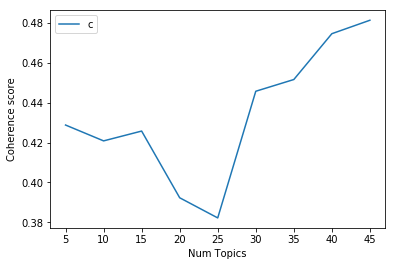

Num Topics = 5  has Coherence Value of 0.4288
Num Topics = 10  has Coherence Value of 0.4209
Num Topics = 15  has Coherence Value of 0.4258
Num Topics = 20  has Coherence Value of 0.3923
Num Topics = 25  has Coherence Value of 0.3822
Num Topics = 30  has Coherence Value of 0.4458
Num Topics = 35  has Coherence Value of 0.4517
Num Topics = 40  has Coherence Value of 0.4747
Num Topics = 45  has Coherence Value of 0.4814


In [25]:
# Show graph
limit=default_limit; start=default_start; step=default_step;
x = range(start, limit, step)
plt.plot(x, coherence_values_c_v)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

nr_topics_c_v = 1
coherence_max_c_v = 0

# Print the coherence scores
for m, cv in zip(x, coherence_values_c_v):
    if cv > coherence_max_c_v:
        coherence_max_c_v = cv
        nr_topics_c_v = m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Coherence u_mass
We're also calculating coherence on the same model using u_mass, this way we can compare the different coherence measures. u_mass is usually a bit faster than c_v but this might come at the cost of accuracy.

In [26]:
# Can take a long time to run.
model_list, coherence_values_u_mass = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=default_start, limit=default_limit, step=default_step, coherence_type='u_mass')

100%|█████████████████████████████████████████| 9/9 [1:05:37<00:00, 437.46s/it]


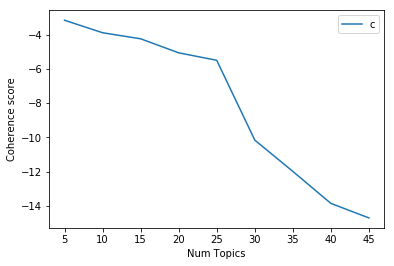

Num Topics = 5  has Coherence Value of -3.1542
Num Topics = 10  has Coherence Value of -3.8848
Num Topics = 15  has Coherence Value of -4.2391
Num Topics = 20  has Coherence Value of -5.059
Num Topics = 25  has Coherence Value of -5.4969
Num Topics = 30  has Coherence Value of -10.1623
Num Topics = 35  has Coherence Value of -11.993
Num Topics = 40  has Coherence Value of -13.8638
Num Topics = 45  has Coherence Value of -14.7141


In [27]:
# Show graph
limit=default_limit; start=default_start; step=default_step;
x = range(start, limit, step)
plt.plot(x, coherence_values_u_mass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

nr_topics_u_mass = 1
coherence_max_u_mass = 0

# Print the coherence scores
for m, cv in zip(x, coherence_values_u_mass):
    if cv > coherence_max_u_mass:
        coherence_max_u_mass = cv
        nr_topics_u_mass = m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

To find the optimal number of topics we calculate the maximum second derivative, this will result in the point with the steepest increase in coherence.

In [28]:
def elbowPoint(points):
    secondDerivative = collections.defaultdict(lambda:0)
    for i in range(1, len(points) - 1):
        secondDerivative[i] = points[i+1] + points[i-1] - 2*points[i]

    max_index = list(secondDerivative.values()).index(max(secondDerivative.values()))
    elbow_point = max_index + 1
    return elbow_point

In [29]:
points_lda_c_v = coherence_values_c_v
points_lda_u_mass = coherence_values_u_mass
max_point_lda_c_v = elbowPoint(points_lda_c_v)
max_point_lda_u_mass = elbowPoint(points_lda_u_mass)
print("Optimal number of topics according to c_v coherence:", max_point_lda_c_v)
print("Optimal number of topics according to u_mass coherence:", max_point_lda_u_mass)

Optimal number of topics according to c_v coherence: 4
Optimal number of topics according to u_mass coherence: 5


In [30]:
# Build optimal LDA model

lda_optimal_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=max_point_lda_c_v, 
                                       random_state=randomseed,
                                       chunksize=100,
                                       update_every=1,
                                       passes=10,
                                       per_word_topics=True)

In [31]:
# Print the Keyword in the 10 topics
pprint(lda_optimal_model.print_topics())
doc_lda_optimal = lda_optimal_model[corpus]

[(0,
  '0.027*"vinden" + 0.027*"opleiding" + 0.024*"docent" + 0.018*"student" + '
  '0.017*"vak" + 0.015*"gaan" + 0.015*"krijgen" + 0.014*"erg" + 0.014*"moeten" '
  '+ 0.014*"toets"'),
 (1,
  '0.047*"goed" + 0.039*"stage" + 0.036*"student" + 0.028*"jaar" + '
  '0.023*"duidelijk" + 0.019*"begeleiding" + 0.018*"rooster" + '
  '0.016*"informatie" + 0.014*"communicatie" + 0.013*"minor"'),
 (2,
  '0.032*"les" + 0.025*"goed" + 0.018*"student" + 0.017*"werken" + '
  '0.017*"docent" + 0.012*"uur" + 0.011*"vaak" + 0.011*"leerling" + '
  '0.010*"praktijk" + 0.009*"geven"'),
 (3,
  '0.030*"periode" + 0.030*"week" + 0.027*"opdracht" + 0.025*"dag" + '
  '0.018*"tijd" + 0.017*"tentamens" + 0.016*"tentamen" + 0.016*"deadline" + '
  '0.015*"maken" + 0.013*"duidelijkheid"')]


In [32]:
lmtopics = lda_optimal_model.show_topics(formatted=False)

## Building LDA Mallet Model

Mallet’s version should give a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself[5].

In [59]:
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bat' # update this path
mallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=default_topics, id2word=id2word)

# Show Topics
mallet_default_topics = mallet_model.show_topics(formatted=False)
pprint(mallet_default_topics)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=mallet_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('werken', 0.04687641466727026),
   ('zitten', 0.04597102761430512),
   ('vaak', 0.04169307378904482),
   ('waar', 0.03610230873698506),
   ('ruimte', 0.02965142598460842),
   ('school', 0.023766410140334992),
   ('lokaal', 0.020303304662743323),
   ('fijn', 0.018220914440923493),
   ('mogelijkheid', 0.017157084653689453),
   ('groep', 0.01670439112720688)]),
 (1,
  [('vinden', 0.10144516241704506),
   ('vak', 0.07446297589940622),
   ('erg', 0.07441931540342299),
   ('heel', 0.0506898358365351),
   ('krijgen', 0.04507946210268949),
   ('wel', 0.04479566887879846),
   ('mogen', 0.027353300733496334),
   ('echt', 0.026152637093957386),
   ('willen', 0.022856269647223194),
   ('graag', 0.02141547327977646)]),
 (2,
  [('docent', 0.1583453822519429),
   ('goed', 0.07111874209289716),
   ('geven', 0.06752665823242364),
   ('toets', 0.03189951201879631),
   ('feedback', 0.022840231339237304),
   ('opdracht', 0.022682089282486897),
   ('duidelijk', 0.02132658593891198),
   ('manier', 

### Finding optimal number of topics for Mallet LDA

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

100%|████████████████████████████████████████████| 9/9 [13:45<00:00, 91.73s/it]


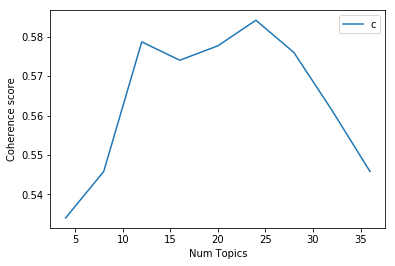

Num Topics = 4  has Coherence Value of 0.5341
Num Topics = 8  has Coherence Value of 0.5458
Num Topics = 12  has Coherence Value of 0.5786
Num Topics = 16  has Coherence Value of 0.574
Num Topics = 20  has Coherence Value of 0.5776
Num Topics = 24  has Coherence Value of 0.5841
Num Topics = 28  has Coherence Value of 0.5759
Num Topics = 32  has Coherence Value of 0.5613
Num Topics = 36  has Coherence Value of 0.5458


In [35]:
def compute_coherence_values_mallet(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_mallet(dictionary=id2word, corpus=corpus, texts=data_words, start=4, limit=40, step=4)
# Show graph
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

nr_topics = 1
coherence_max = 0

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    if cv > coherence_max:
        coherence_max = cv
        nr_topics = m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [36]:
points = coherence_values
max_point = elbowPoint(points)
print(max_point)

1


In [39]:
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet.bat' # update this path
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=max_point, id2word=id2word)

# Show Topics
mallettopics = optimal_model.show_topics(formatted=False)
pprint(mallettopics)

# Compute Coherence Score
coherence_model_ldamallet_optimal = CoherenceModel(model=optimal_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_ldamallet_optimal = coherence_model_ldamallet_optimal.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet_optimal)

[(0,
  [('docent', 0.12589811754562438),
   ('goed', 0.06550869377784165),
   ('geven', 0.05309670929731283),
   ('toets', 0.04160080471332088),
   ('moeten', 0.025290990084782295),
   ('vraag', 0.02211165397327202),
   ('feedback', 0.01815993677252479),
   ('manier', 0.01591464290846386),
   ('snel', 0.013920821957177755),
   ('groot', 0.013615461991665469)]),
 (1,
  [('jaar', 0.08325394305070392),
   ('vinden', 0.08194841395857591),
   ('erg', 0.060142549663032355),
   ('heel', 0.043400021170742036),
   ('hebben', 0.027804241205320913),
   ('periode', 0.027345541794573235),
   ('volgen', 0.020588546628559332),
   ('halen', 0.018894887265798667),
   ('laat', 0.01824212271973466),
   ('pas', 0.014854803994213331)]),
 (2,
  [('wel', 0.04906590735467741),
   ('gaan', 0.03797138690186819),
   ('krijgen', 0.030088895062157093),
   ('weten', 0.025765678172095283),
   ('echt', 0.02524480866726856),
   ('doen', 0.024741301479269395),
   ('leraar', 0.02317869296478922),
   ('leerling', 0.02317

In [40]:
pyLDAvis.enable_notebook()
mallet_pyldavis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis_malletoptimal = pyLDAvis.gensim.prepare(mallet_pyldavis, corpus, id2word)
vis_malletoptimal

C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Tobias\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.138129 -0.163283       1        1  12.958953
1     -0.210450  0.121820       2        1  12.805383
3     -0.189577 -0.288925       3        1  12.688888
0      0.213639 -0.127382       4        1  12.462829
5      0.131294  0.103368       5        1  12.345189
6      0.216360 -0.038205       6        1  12.322985
7      0.158045  0.121896       7        1  12.249454
4     -0.181181  0.270710       8        1  12.166318, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
63    Default  7027.000000        docent  7027.000000  30.0000  30.0000
138   Default  9262.000000       student  9262.000000  29.0000  29.0000
46    Default  6402.000000     opleiding  6402.000000  28.0000  28.0000
106   Default  4774.000000          jaar  4774.000000  27.0000  27.0000
49    Default  4701.000000        vinden  4701.000000  26.0000  26.0000
1     Default  9683.000000          goed  9683.000000  25.0000  25.0000
24    Default  3680.000000         stage  3680.000000  24.0000  24.0000
85    Default  3590.000000           les  3590.000000  23.0000  23.0000
37    Default  3449.000000           erg  3449.000000  22.0000  22.0000
25    Default  3409.000000           vak  3409.000000  21.0000  21.0000
65    Default  3670.000000         geven  3670.000000  20.0000  20.0000
15    Default  2847.000000           wel  2847.000000  19.0000  19.0000
82    Default  2527.000000          heel  2527.000000  18.0000  18.0000
33    Default  2376.000000          tijd  2376.000000  17.0000  17.0000
152   Default  2322.000000         toets  2322.000000  16.0000  16.0000
23    Default  2300.000000        school  2300.000000  15.0000  15.0000
16    Default  2077.000000        werken  2077.000000  14.0000  14.0000
122   Default  2066.000000        zitten  2066.000000  13.0000  13.0000
17    Default  2007.000000     duidelijk  2007.000000  12.0000  12.0000
163   Default  2814.000000          vaak  2814.000000  11.0000  11.0000
339   Default  3195.000000          gaan  3195.000000  10.0000  10.0000
303   Default  1780.000000   begeleiding  1780.000000   9.0000   9.0000
44    Default  2581.000000       krijgen  2581.000000   8.0000   8.0000
14    Default  1739.000000          week  1739.000000   7.0000   7.0000
173   Default  1967.000000    informatie  1967.000000   6.0000   6.0000
97    Default  2277.000000          waar  2277.000000   5.0000   5.0000
31    Default  1603.000000      opdracht  1603.000000   4.0000   4.0000
20    Default  3891.000000         maken  3891.000000   3.0000   3.0000
2     Default  1597.000000        hebben  1597.000000   2.0000   2.0000
6     Default  1569.000000       periode  1569.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
269    Topic8   491.958276      computer   492.957601   2.1045  -4.7074
272    Topic8   461.899725          open   462.907556   2.1043  -4.7704
534    Topic8   449.876305          boek   450.876478   2.1043  -4.7968
107    Topic8   358.698702        rustig   358.698702   2.1065  -5.0233
528    Topic8   345.673330  studieruimte   345.673330   2.1065  -5.0603
622    Topic8   417.813851       gebruik   418.814024   2.1041  -4.8707
277    Topic8   317.618683   stopcontact   317.618683   2.1065  -5.1449
600    Topic8   308.601118   individueel   308.601118   2.1065  -5.1737
1409   Topic8   308.601118         samen   308.601118   2.1065  -5.1737
377    Topic8   301.587456    werkruimte   301.587456   2.1065  -5.1967
538    Topic8   297.579650    mediatheek   297.579650   2.1065  -5.2101
1228   Topic8   280.546471          vast   280.546471   2.1065  -5.2690
416    Topic8   244.476210      beperken   244.476210   2.1065  -5.4067
367    Topic8   228.444984          duur   228.444984   2.1065  -5.4745
1566   Topic8   228.444984       

### Most representative sentences
To make these topics more interpretable for our clients, we print the sentences that contributed most to the topics. Using these sentences it's easier to understand what a topic is about.

In [41]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    df_representative_sentences = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                df_representative_sentences = df_representative_sentences.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    df_representative_sentences.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    texts_resetindex = documents['Opmerking'].reset_index(drop=True)
    contents = pd.Series(texts_resetindex)
    df_representative_sentences = pd.concat([df_representative_sentences, contents], axis=1)
    return(df_representative_sentences)


df_topics_sentences = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents['Opmerking'])

# Save
df_topics_sentences.to_csv("df_topics_sentences.csv")

# Show
df_topics_sentences

Dominant_Topic  Perc_Contribution  \
0                 5.0             0.2014   
1                 6.0             0.1542   
2                 5.0             0.1786   
3                 1.0             0.1743   
4                 0.0             0.1864   
5                 0.0             0.2105   
6                 2.0             0.2038   
7                 1.0             0.2477   
8                 2.0             0.1687   
9                 2.0             0.1746   
10                0.0             0.1991   
11                7.0             0.1706   
12                0.0             0.1708   
13                1.0             0.1444   
14                4.0             0.2008   
15                5.0             0.1611   
16                6.0             0.1439   
17                3.0             0.1723   
18                3.0             0.1569   
19                7.0             0.1605   
20                5.0             0.1809   
21                1.0             0.2092   
22                4.0             0.2734   
23                2.0             0.1422   
24                3.0             0.1750   
25                0.0             0.1447   
26                3.0             0.1543   
27                0.0             0.2191   
28                3.0             0.1717   
29                1.0             0.1457   
...               ...                ...   
27587             7.0             0.1844   
27588             3.0             0.2106   
27589             1.0             0.1797   
27590             3.0             0.1806   
27591             4.0             0.1713   
27592             2.0             0.1546   
27593             0.0             0.1671   
27594             6.0             0.1838   
27595             5.0             0.1727   
27596             0.0             0.1720   
27597             7.0             0.1857   
27598             1.0             0.1595   
27599             3.0             0.1564   
27600             0.0             0.1750   
27601             5.0             0.1560   
27602             5.0             0.2054   
27603             5.0             0.1671   
27604             4.0             0.1888   
27605             1.0             0.1560   
27606             0.0             0.1473   
27607             3.0             0.1670   
27608             5.0             0.1748   
27609             0.0             0.1533   
27610             4.0             0.1713   
27611             6.0             0.1530   
27612             6.0             0.1779   
27613             3.0             0.1761   
27614             0.0             0.1507   
27615             5.0             0.1630   
27616             6.0             0.1486   

                                          Topic_Keywords  \
0      les, vak, tijd, week, opdracht, dag, rooster, ...   
1      student, goed, stage, begeleiding, minor, moge...   
2      les, vak, tijd, week, opdracht, dag, rooster, ...   
3      jaar, vinden, erg, heel, hebben, periode, volg...   
4      docent, goed, geven, toets, moeten, vraag, fee...   
5      docent, goed, geven, toets, moeten, vraag, fee...   
6      wel, gaan, krijgen, weten, echt, doen, leraar,...   
7      jaar, vinden, erg, heel, hebben, periode, volg...   
8      wel, gaan, krijgen, weten, echt, doen, leraar,...   
9      wel, gaan, krijgen, weten, echt, doen, leraar,...   
10     docent, goed, geven, toets, moeten, vraag, fee...   
11     student, duidelijk, maken, informatie, communi...   
12     docent, goed, geven, toets, moeten, vraag, fee...   
13     jaar, vinden, erg, heel, hebben, periode, volg...   
14     school, werken, zitten, vaak, waar, ruimte, pr...   
15     les, vak, tijd, week, opdracht, dag, rooster, ...   
16     student, goed, stage, begeleiding, minor, moge...   
17     opleiding, praktijk, kennis, zeer, onderwijs, ...   
18     opleiding, praktijk, kennis, zeer, onderwijs, ...   
19     student, duidelijk, maken, informatie, communi...   
20     les, vak, t

In [42]:
df_topics_years = documents['Jaar'].reset_index()
df_topics_sentences['Year'] = df_topics_years['Jaar']

In [43]:
# Group top 5 sentences under each topic
df_most_contributed_sentences = pd.DataFrame()

sent_topics_outdf_grpd = df_topics_sentences.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    df_most_contributed_sentences = pd.concat([df_most_contributed_sentences, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
df_most_contributed_sentences.reset_index(drop=True, inplace=True)

# Format
df_most_contributed_sentences.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Year"]

# Save
df_most_contributed_sentences.to_csv("df_most_contributed_sentences.csv")

# Show
df_most_contributed_sentences

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.3896   
1         0.0              0.3376   
2         0.0              0.3231   
3         0.0              0.3189   
4         0.0              0.3174   
5         1.0              0.3463   
6         1.0              0.3347   
7         1.0              0.3273   
8         1.0              0.3177   
9         1.0              0.3035   
10        2.0              0.3553   
11        2.0              0.3235   
12        2.0              0.3216   
13        2.0              0.3037   
14        2.0              0.2948   
15        3.0              0.3943   
16        3.0              0.3719   
17        3.0              0.3336   
18        3.0              0.3310   
19        3.0              0.3298   
20        4.0              0.3953   
21        4.0              0.3922   
22        4.0              0.3646   
23        4.0              0.3614   
24        4.0              0.3611   
25        5.0              0.3759   
26        5.0              0.3294   
27        5.0              0.3176   
28        5.0              0.3132   
29        5.0              0.3024   
30        6.0              0.3135   
31        6.0              0.3115   
32        6.0              0.3107   
33        6.0              0.3106   
34        6.0              0.3089   
35        7.0              0.3068   
36        7.0              0.3061   
37        7.0              0.3027   
38        7.0              0.2971   
39        7.0              0.2892   

                                             Keywords  \
0   docent, goed, geven, toets, moeten, vraag, fee...   
1   docent, goed, geven, toets, moeten, vraag, fee...   
2   docent, goed, geven, toets, moeten, vraag, fee...   
3   docent, goed, geven, toets, moeten, vraag, fee...   
4   docent, goed, geven, toets, moeten, vraag, fee...   
5   jaar, vinden, erg, heel, hebben, periode, volg...   
6   jaar, vinden, erg, heel, hebben, periode, volg...   
7   jaar, vinden, erg, heel, hebben, periode, volg...   
8   jaar, vinden, erg, heel, hebben, periode, volg...   
9   jaar, vinden, erg, heel, hebben, periode, volg...   
10  wel, gaan, krijgen, weten, echt, doen, leraar,...   
11  wel, gaan, krijgen, weten, echt, doen, leraar,...   
12  wel, gaan, krijgen, weten, echt, doen, leraar,...   
13  wel, gaan, krijgen, weten, echt, doen, leraar,...   
14  wel, gaan, krijgen, weten, echt, doen, leraar,...   
15  opleiding, praktijk, kennis, zeer, onderwijs, ...   
16  opleiding, praktijk, kennis, zeer, onderwijs, ...   
17  opleiding, praktijk, kennis, zeer, onderwijs, ...   
18  opleiding, praktijk, kennis, zeer, onderwijs, ...   
19  opleiding, praktijk, kennis, zeer, onderwijs, ...   
20  school, werken, zitten, vaak, waar, ruimte, pr...   
21  school, werken, zitten, vaak, waar, ruimte, pr...   
22  school, werken, zitten, vaak, waar, ruimte, pr...   
23  school, werken, zitten, vaak, waar, ruimte, pr...   
24  school, werken, zitten, vaak, waar, ruimte, pr...   
25  les, vak, tijd, week, opdracht, dag, rooster, ...   
26  les, vak, tijd, week, opdracht, dag, rooster, ...   
27  les, vak, tijd, week, opdracht, dag, rooster, ...   
28  les, vak, tijd, week, opdracht, dag, rooster, ...   
29  les, vak, tijd, week, opdracht, dag, rooster, ...   
30  student, goed, stage, begeleiding, minor, moge...   
31  student, goed, stage, begeleiding, minor, moge...   
32  student, goed, stage, begeleiding, minor, moge...   
33  student, goed, stage, begeleiding, minor, moge...   
34  student, goed, stage, begeleiding, minor, moge...   
35  student, duidelijk, maken, informatie, communi...   
36  student, duidelijk, maken, informatie, communi...   
37  student, duidelijk, maken, informatie, communi...   
38  student, duidelijk, maken, informatie, communi...   
39  student, duidelijk, maken, informatie, communi...   

                                                 Text  Year  
0   naar mijn mening is verbetering mogelijk in de...  2014  
1   tijdens de afstudeer

### Print occurences of topics for every year
After generating topics on the data, we can look at occurences of a specific topic over the years to see if it increased or decreased.

In [44]:
years = documents['Jaar'].unique()
print(years)

[2013 2014 2015 2016 2017 2018]


In [45]:
print(df_topics_sentences['Dominant_Topic'].loc[df_topics_sentences['Year'] == 2013])

0       5.0
1       6.0
2       5.0
3       1.0
4       0.0
5       0.0
6       2.0
7       1.0
8       2.0
9       2.0
10      0.0
11      7.0
12      0.0
13      1.0
14      4.0
15      5.0
16      6.0
17      3.0
18      3.0
19      7.0
20      5.0
21      1.0
22      4.0
23      2.0
24      3.0
25      0.0
26      3.0
27      0.0
28      3.0
29      1.0
       ... 
3859    3.0
3860    5.0
3861    7.0
3862    4.0
3863    0.0
3864    1.0
3865    2.0
3866    6.0
3867    7.0
3868    5.0
3869    0.0
3870    0.0
3871    7.0
3872    0.0
3873    5.0
3874    4.0
3875    1.0
3876    5.0
3877    4.0
3878    7.0
3879    0.0
3880    1.0
3881    2.0
3882    7.0
3883    6.0
3884    0.0
3885    1.0
3886    0.0
3887    5.0
3888    1.0
Name: Dominant_Topic, Length: 3889, dtype: float64


In [46]:
yearsarray={}
for y in years:
    print(y)
    df_topic_year_dominant_topic = df_topics_sentences['Dominant_Topic'].loc[df_topics_sentences['Year'] == y]
    yearsarray[y] = np.asarray(df_topic_year_dominant_topic)
    print(Counter(yearsarray[y]))

2013
Counter({4.0: 644, 7.0: 585, 0.0: 571, 3.0: 479, 5.0: 474, 6.0: 422, 1.0: 378, 2.0: 336})
2014
Counter({4.0: 707, 7.0: 590, 0.0: 577, 3.0: 536, 5.0: 506, 6.0: 459, 1.0: 391, 2.0: 360})
2015
Counter({4.0: 880, 0.0: 731, 3.0: 652, 5.0: 643, 7.0: 619, 6.0: 505, 2.0: 488, 1.0: 472})
2016
Counter({4.0: 899, 0.0: 728, 3.0: 722, 5.0: 690, 7.0: 684, 6.0: 677, 2.0: 526, 1.0: 521})
2017
Counter({5.0: 743, 3.0: 716, 6.0: 634, 0.0: 612, 4.0: 607, 7.0: 550, 1.0: 460, 2.0: 459})
2018
Counter({5.0: 659, 3.0: 659, 0.0: 624, 6.0: 602, 4.0: 494, 7.0: 492, 1.0: 449, 2.0: 405})


## Evaluating all the topic models
Comparing coherence for all topic models, to see which topic model would give us the most human interpretable topics.

In [62]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]
mallet_default_topics = [[word for word, prob in topic] for topicid, topic in mallet_default_topics]
mallettopics = [[word for word, prob in topic] for topicid, topic in mallettopics]

In [63]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=data_words, dictionary=id2word, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=data_words, dictionary=id2word, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=data_words, dictionary=id2word, window_size=10).get_coherence()
lm_coherence = CoherenceModel(topics=lmtopics, texts=data_words, dictionary=id2word, window_size=10).get_coherence()
mallet_default_coherence = CoherenceModel(topics=mallet_default_topics, texts=data_words, dictionary=id2word, window_size=10).get_coherence()
mallet_coherence = CoherenceModel(topics=mallettopics, texts=data_words, dictionary=id2word, window_size=10).get_coherence()
#lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=corpus, dictionary=id2word, window_size=10).get_coherence()

In [49]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

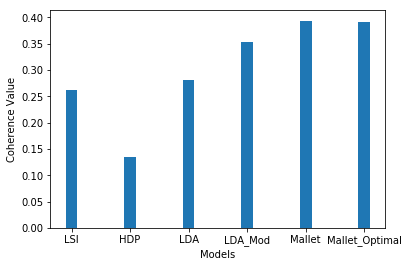

In [64]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, mallet_default_coherence, mallet_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'Mallet', 'Mallet_Optimal'])

## References

[1] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). An Introduction to Latent Semantic Analysis. Retrieved from http://lsa.colorado.edu/papers/dp1.LSAintro.pdf<br>
[2] Teh, Y. W., Jordan, M. I., Beal, M. J., Blei, D. M. (2005, December 15th). Hierarchical Dirichlet Processes. Retrieved from http://www.gatsby.ucl.ac.uk/~ywteh/research/npbayes/jasa2006.pdf<br>
[3] David M. Blei, Andrew Y. Ng, Michael I. Jordan (2003, January 3rd). Latent Dirichlet Allocation. Retrieved from http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf<br>
[4] Röder, M., Both, A., Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. Retrieved from http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf.<br>
[5] McCallum, Andrew Kachites (2002). MALLET: A Machine Learning for Language Toolkit. Retrieved from http://mallet.cs.umass.edu.<br>